In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.autolayout"] = True

In [2]:
import torch
from torch import nn, optim
from utils import Legendre_Polynomials, Finite_Elements
import torch.nn.functional as F

## Define the parameters of the equation

In [84]:
# f = lambda x: x ** -.25  # Source function
f = lambda x: 1  # Source function
k = 5. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 2., 1.  # Values at the boundaries

## Train the neural network

In [85]:
from solvers import Exact_HelmholtzImpedance_const
u, u_x = Exact_HelmholtzImpedance_const(f(0), k, a, b, ga, gb)

In [86]:
from solvers import VPINN_HelmholtzImpedance

testfuncs = 1000
width = 1000
depth = 1
activation = F.relu
penalty = None

cuda = False
epochs = 60000
lr = 1e-01
seed = None
dropout_probs = None

model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                N_quad=100,
                                seed=seed,
                                cuda=cuda,
                                )

# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)()
testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)()
if cuda:
  model = model.cuda()
# optimizer = optim.Adam([
#   {'params': model.lins[0].weight, 'lr': 0},
#   {'params': model.lins[0].bias, 'lr': 0},
#   {'params': model.lins[1].weight, 'lr': lr},
#   {'params': model.lins[1].bias, 'lr': 0},
#   ], lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50, min_lr=1e-08, verbose=True)
# losses, errors = model.train_(testfunctions, epochs, optimizer, scheduler, exact=(u, u_x))

/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:139: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


### Perfect initialization

In [87]:
points = torch.linspace(a, b, width + 1).float()
derivs = torch.zeros_like(model.lins[1].weight)
for i, point, next in zip(range(width), points[:-1], points[1:]):
    derivs[0, i] = .5 * (u_x(point).real + u_x(next).real)
    derivs[1, i] = .5 * (u_x(point).imag + u_x(next).imag)
steps = derivs.clone()
for i in range(width - 1):
    steps[0, i + 1] = derivs[0, i + 1] - derivs[0, i]
    steps[1, i + 1] = derivs[1, i + 1] - derivs[1, i]

model.lins[0].bias = nn.Parameter(-1 * points[:-1])
model.lins[1].weight = nn.Parameter(steps.float())
model.lins[1].bias = nn.Parameter(torch.tensor([u(a).real, u(a).imag]).float())

### Custom training

In [42]:
optimizer = optim.Adam([
  # {'params': model.lins[0].weight, 'lr': 0},
  # {'params': model.lins[0].bias, 'lr': 0},
  # {'params': model.lins[1].weight, 'lr': 1e-04},
  {'params': model.lins[1].bias, 'lr': 1e-02},
  ], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-03, min_lr=1e-08, verbose=True)
losses, errors = model.train_(testfunctions, 100, optimizer, scheduler, exact=(u, u_x))

Epoch 000000 / 100: loss = 3.123e+05, H1-error = 4.479e+01
Epoch 000100 / 100: loss = 1.116e+01, H1-error = 5.249e+01


## Plot the parameters

In [ ]:
# for n, p in model.named_parameters():
#     print(n, p)

In [ ]:
# plt.rcParams['figure.figsize'] = [15, 10]
# fig, axs = plt.subplots(3, 1)
# fig.tight_layout(pad=4.0)
# fig.suptitle(f'Parameters of the model')

# axs[0].scatter(np.arange(1, width + 1), model.lins[0].weight.detach().view(-1).numpy(), label='$w_n$')
# axs[1].scatter(np.arange(1, width + 1), model.lins[0].bias.detach().view(-1).numpy(), label='$b_n$')
# axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[0].detach().view(-1).numpy(), label='$c^1_n$')
# axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[1].detach().view(-1).numpy(), label='$c^2_n$')
# for ax in axs:
#     ax.grid()
#     ax.legend()

# print(f'Last layer bias: {model.lins[1].bias}')

## Evaluate the results

In [88]:
errs = model.H1_error(u, u_x)
print(f'H1-error: \t\t{errs[0].item():.2e}')
print(f'Solution L2-error: \t{errs[1].item():.2e}')
print(f'Derivative L2-error: {errs[2].item():.2e}')

H1-error: 		3.92e+00
Solution L2-error: 	1.80e+00
Derivative L2-error: 2.12e+00


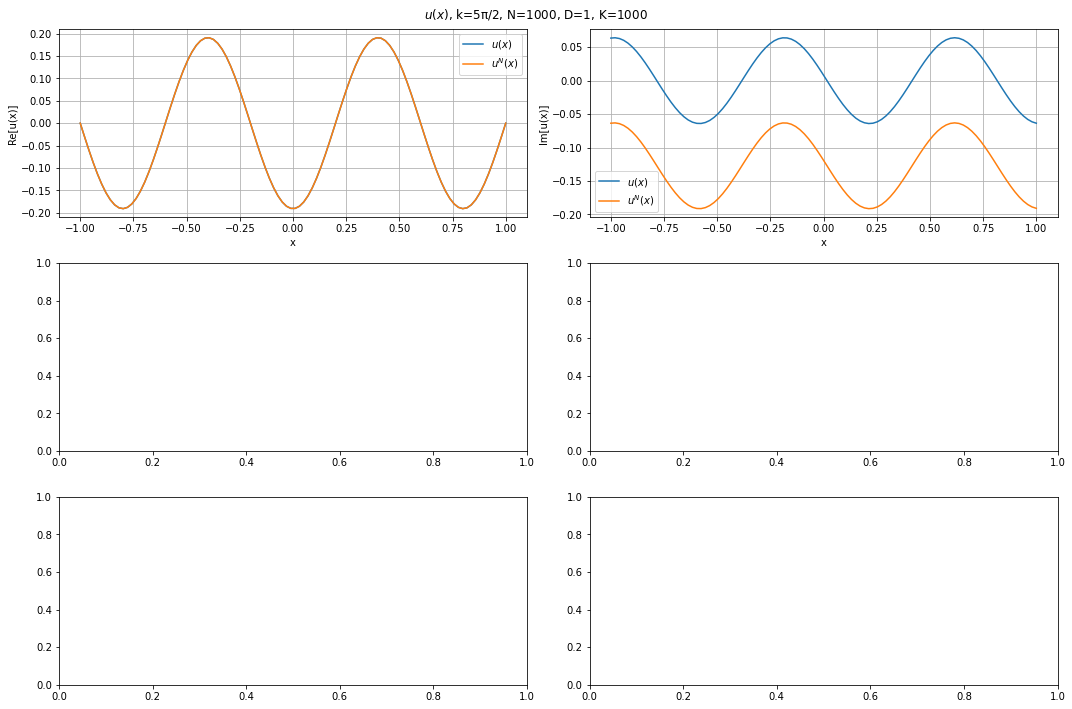

In [89]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u(xpts).real, u(xpts).imag
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u(x)-u^N(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u(x)-u^N(x)]$')
# axs[2, 1].grid()

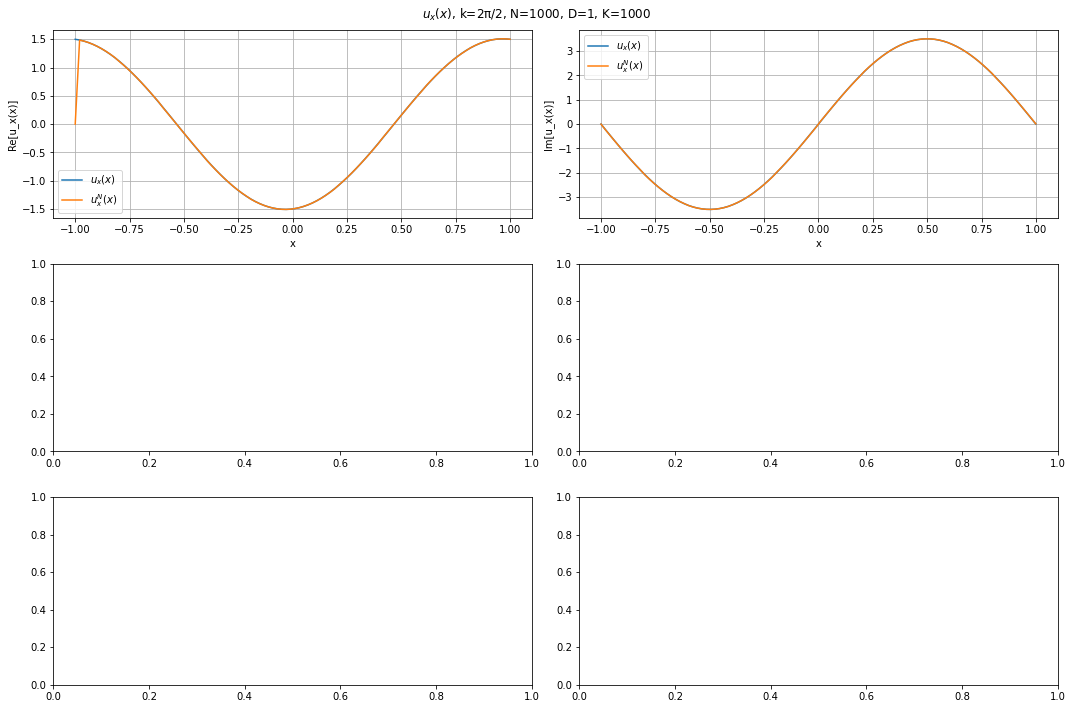

In [83]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u_x(xpts).real, u_x(xpts).imag
xpts.requires_grad_()
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u_x(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u_x(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N_x(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u_x(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N_x(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u_x(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u_x(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

# axs[2, 0].plot(xpts, upts.real - rpts.real)
# axs[2, 0].set(xlabel='x', ylabel='$Re[u_x(x)-u^N_x(x)]$')
# axs[2, 0].grid()
# axs[2, 1].plot(xpts, upts.imag - rpts.imag)
# axs[2, 1].set(xlabel='x', ylabel='$Im[u_x(x)-u^N_x(x)]$')
# axs[2, 1].grid()